In [18]:
#Importing necessary libraries
import pyodbc
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(pyodbc.drivers())

FileNotFoundError: [Errno 2] No such file or directory: 'null/Users/dinakardsm'

In [4]:
#Establish connection with Database
connection_string = """Driver={ODBC Driver 18 for SQL Server};
                       Server=tcp:techentmar.database.windows.net,1433;
                       Database=QAECECRM_Mar2025;
                       Uid=dbadmin;
                       Pwd=DashTech1234;
                       Encrypt=yes;
                       TrustServerCertificate=no;
                       Connection Timeout=30;"""

connection = pyodbc.connect(connection_string)

In [5]:
#Cleaning Functions

def extract_amount(x):
    # Updated regex to include optional minus sign and commas
    match = re.search(r'\(\$ (-?[\d,]+\.\d+)\)', str(x))
    if match:
        return float(match.group(1).replace(',', ''))
    else:
        return np.nan

In [6]:
#Querying all important tables

#Querying the Contracts Data using the Stored Procedure #Run-Time: 6 min 8 sec
query_contract = "EXEC Sp_Get_Contract_Export"
Contract_df = pd.read_sql(query_contract, connection)

BlueCard_df = pd.read_csv('BlueCard_Procedure_Export.csv', low_memory = False)
Presenter_df = pd.read_csv('Presenter_data_query.csv', low_memory = False)
Venue_df = pd.read_csv('Venue_Procedure_Export.csv', low_memory = False)
Lead_df = pd.read_csv('Lead_Procedure_Export.csv', low_memory = False)

In [7]:
#Removing Missing Data
#Contracts Data
Contract_df.dropna(inplace = True)

#BlueCard Data
BlueCard_df.dropna(subset = ['FIRST EVENT DATE'],inplace = True)

#Presenter Data
Presenter_df.dropna(subset = ['PHYSICAL CITY/STATE'], inplace = True)

#Lead Data
Lead_df.dropna(subset = ['AGENT', 'HOME OFFICE', 'EVENT DATE', 'CLOSED DATE', 'REFERRAL SOURCE'], inplace = True)

# ---------------------------------------------------------------------------------------------------------------------------------

#Data Cleaning
#Contracts Data
Contract_df['ARTIST NET_CLEANED'] = Contract_df['ARTIST NET'].apply(extract_amount)

#Presenter Data
Presenter_df['PHYSICAL CITY/STATE'].str.strip()
Presenter_df['PHYSICAL CITY/STATE'].replace(' --', np.nan, inplace = True)

# -----------------------------------------------------------------------------------------------------------------------------------

#Feature Engineering
#Contracts Data
Contract_df['EVENT DATE YEAR'] = pd.to_datetime(Contract_df['FIRST EVENT DATE'], errors = 'coerce').dt.year

#BlueCard Data
BlueCard_df['CREATED DATE'] = pd.to_datetime(BlueCard_df['CREATED DATE'], errors = 'coerce')
BlueCard_df.sort_values('CREATED DATE', inplace = True)
BlueCard_df['Blue Card Rolling Count'] = BlueCard_df.reset_index().index + 1 #Getting rolling Count of Blue Cards through Time
BlueCard_df['CREATED YEAR'] = BlueCard_df['CREATED DATE'].dt.year

#Lead Data
Lead_df['EVENT DATE'] = pd.to_datetime(Lead_df['EVENT DATE'], errors = 'coerce')

In [8]:
# Step 1: Preprocessing - Normalize keys in both datasets
def normalize_str(s):
    if isinstance(s, str):
        return s.strip().lower()
    return s

#Cleaning string data
Contract_df["PRESENTER_CLEAN"] = Contract_df["PRESENTER"].apply(normalize_str)
Contract_df["VENUE_CLEAN"] = Contract_df["VENUE NAME"].apply(normalize_str)
Contract_df["AGENT_CLEAN"] = Contract_df["AGENT"].apply(normalize_str)

BlueCard_df["PRESENTER_CLEAN"] = BlueCard_df["PRESENTER"].apply(normalize_str)
BlueCard_df["VENUE_CLEAN"] = BlueCard_df["VENUE NAME"].apply(normalize_str)
BlueCard_df["AGENT_CLEAN"] = BlueCard_df["AGENT"].apply(normalize_str)

#Cleaning datetime data
Contract_df["EVENT_DATE_CLEAN"] = pd.to_datetime(Contract_df["FIRST EVENT DATE"], errors="coerce")
BlueCard_df["EVENT_DATE_CLEAN"] = pd.to_datetime(BlueCard_df["FIRST EVENT DATE"], errors="coerce")
BlueCard_df["CREATED DATE"] = pd.to_datetime(BlueCard_df['CREATED DATE'], errors = 'coerce')

# Step 2: Generate merge keys
Contract_df["MATCH_KEY"] = (
    Contract_df["PRESENTER_CLEAN"] + "_" +
    Contract_df["VENUE_CLEAN"].fillna("na") + "_" +
    Contract_df["EVENT_DATE_CLEAN"].dt.strftime('%Y-%m-%d')
)

BlueCard_df["MATCH_KEY"] = (
    BlueCard_df["PRESENTER_CLEAN"] + "_" +
    BlueCard_df["VENUE_CLEAN"].fillna("na") + "_" +
    BlueCard_df["EVENT_DATE_CLEAN"].dt.strftime('%Y-%m-%d')
)

# Step 3: Drop duplicates in bluecards to retain earliest CREATED DATE per match key
bluecards_deduped = (
    BlueCard_df.sort_values("CREATED DATE")
    .drop_duplicates("MATCH_KEY")
    .set_index("MATCH_KEY")
)

# Step 4: Merge using MATCH_KEY
Contract_df["MATCH_KEY"] = Contract_df["MATCH_KEY"].astype(str)

contracts_enriched = Contract_df.set_index("MATCH_KEY").join(
    bluecards_deduped[["# BLUE CARD", "CREATED DATE", "EVENT_DATE_CLEAN"]],
    how="left",
    rsuffix="_BLUECARD"
).reset_index()

In [9]:
contracts_enriched['OVERDUE_DEPOSIT_FLAG'] = contracts_enriched['OVERDUE DEPOSIT'].astype(str).str.lower().eq('yes').astype(int) #Indicates delay in financial commitment
contracts_enriched['OVERDUE_SIGNATURE_FLAG'] = contracts_enriched['OVERDUE SIGNATURE'].astype(str).str.lower().eq('yes').astype(int) #Indicates late formalization of contract

#Surface-level contract lifecycle risk - Flags unstable or failing contracts without needing numeric logic
status_keywords = ['cancel', 'overdue', 'pending', 'hold']
contracts_enriched['STATUS_RISK_FLAG'] = contracts_enriched['STATUS'].astype(str).str.lower().apply(
    lambda x: int(any(k in x for k in status_keywords))
)

#Financial reconciliation check - Large positive/negative discrepancies may 
#signal pricing issues, miscontracts, or hidden costs
contracts_enriched["FINANCIAL_DELTA"] = (
    contracts_enriched["$GROSS"] - 
    contracts_enriched["ARTIST NET_CLEANED"] - 
    contracts_enriched["$ECE TOTAL COMMISSION"]
)

#Days between contract issuance and event - Measures lead time for planning
contracts_enriched["ISSUE_TO_EVENT_DAYS"] = (
    pd.to_datetime(contracts_enriched["EVENT_DATE_CLEAN"], errors="coerce") -
    pd.to_datetime(contracts_enriched["ISSUE DATE"], errors="coerce")
).dt.days

#First-time presenters carry higher uncertainty — no track record
presenter_counts = contracts_enriched["PRESENTER_CLEAN"].value_counts()
contracts_enriched["IS_FIRST_TIME_PRESENTER"] = contracts_enriched["PRESENTER_CLEAN"].map(presenter_counts) == 1

#Detects abnormal financial behavior - Statistically significant financial mismatches; high potential for error or fraud
std_delta = contracts_enriched["FINANCIAL_DELTA"].std()
contracts_enriched["FINANCIAL_ANOMALY_FLAG"] = (contracts_enriched["FINANCIAL_DELTA"].abs() > 3 * std_delta).astype(int)


contracts_enriched['RISK_SCORE'] = (
    (contracts_enriched['$DEPOSIT DUE AMOUNT'] < 500).astype(int) * 3 +
    contracts_enriched['IS_FIRST_TIME_PRESENTER'].astype(int) * 2 +
    (contracts_enriched['ISSUE_TO_EVENT_DAYS'] < 30).astype(int) * 4 +
    contracts_enriched['OVERDUE_DEPOSIT_FLAG'] * 2 +
    contracts_enriched['OVERDUE_SIGNATURE_FLAG'] * 1 +
    contracts_enriched['FINANCIAL_ANOMALY_FLAG'] * 3 +
    contracts_enriched['STATUS_RISK_FLAG'] * 2
)
contracts_enriched.head()

,MATCH_KEY,CONTRACT #,PRESENTER,FIRST ARTIST,FIRST EVENT DATE,NO. OF SHOWS,AGENT,TYPE,STATUS,$GROSS,$ECE TOTAL COMMISSION,ARTIST NET,ISSUE DATE,OVERDUE DEPOSIT,OVERDUE SIGNATURE,OUT OF BALANCE,UNDERWATER,IS ARCHIVED,$DEPOSIT DUE AMOUNT,VENUE NAME,VENUE CITY/STATE,CONTACT NAME,OFFICE,LINE OF BUSINESS,ARTIST NET_CLEANED,EVENT DATE YEAR,PRESENTER_CLEAN,VENUE_CLEAN,AGENT_CLEAN,EVENT_DATE_CLEAN,# BLUE CARD,CREATED DATE,EVENT_DATE_CLEAN_BLUECARD,OVERDUE_DEPOSIT_FLAG,OVERDUE_SIGNATURE_FLAG,STATUS_RISK_FLAG,FINANCIAL_DELTA,ISSUE_TO_EVENT_DAYS,IS_FIRST_TIME_PRESENTER,FINANCIAL_ANOMALY_FLAG,RISK_SCORE
0,"""project halo"" party_project halo site_1999-05-15",251192,"""PROJECT HALO"" PARTY",DADDY BLUE,05/15/1999,1.0,Scooter Abrams,Party,Completed,350.0,50.0,DADDY BLUE ($ 350.00),05/04/1999,NONE,NONE,NONE,NO,YES,50.0,PROJECT HALO SITE,"CHARLOTTE, NC",GUS THOMAS,Charlotte,Core,350.0,1999.0,"""project halo"" party",project halo site,scooter abrams,1999-05-15,NaN,NaT,NaT,0,0,0,-50.0,11.0,True,0,9
1,(cancelled !!!!!!) russell private party_firs...,250485,(CANCELLED !!!!!!) RUSSELL PRIVATE PARTY,THE MAYBERRIES,04/24/1999,1.0,Ed Duncan,Dance,Issued,100.0,100.0,THE MAYBERRIES ($ 0.00),03/15/1999,NONE,NONE,NONE,NO,YES,100.0,FIRST NATIONAL BANK,"SHELBY, NC",PATRICIA S. RUSSELL,Charlotte,Core,0.0,1999.0,(cancelled !!!!!!) russell private party,first national bank,ed duncan,1999-04-24,NaN,NaT,NaT,0,0,0,0.0,40.0,True,0,5
2,(the) shark club_shark club_1999-06-11,603075,(THE) SHARK CLUB,THE COCONUT GROOVE BAND,06/11/1999,1.0,Doug Baker,Club,Completed,2000.0,400.0,"THE COCONUT GROOVE BAND ($ 1,600.00)",03/23/1999,NONE,NONE,NONE,NO,YES,400.0,SHARK CLUB,"CENTREVILLE, VA","ERIC STEENSTRA, ERIC STEESTRA",Columbia,Core,1600.0,1999.0,(the) shark club,shark club,doug baker,1999-06-11,NaN,NaT,NaT,0,0,0,0.0,80.0,True,0,5
3,", executive director of public interest proj_h...",278693,", Executive Director of Public Interest Proj",GASTON,10/22/2009,1.0,Doug Daniel,Party,Fully Executed,1750.0,350.0,"GASTON ($ 1,330.00)",08/31/2009,NONE,NONE,NONE,NO,NO,875.0,HARPER'S GRILL,"CHARLOTTE, NC",GINGER DONNAN,Charlotte,Core,1330.0,2009.0,", executive director of public interest proj",harper's grill,doug daniel,2009-10-22,NaN,NaT,NaT,0,0,0,70.0,52.0,True,0,2
4,",ellow reception_officers club_1995-10-14",600867,",ELLOW RECEPTION",RIPTIDE,10/14/1995,1.0,Doug Baker,Wedding,Completed,1750.0,0.0,RIPTIDE ($ 875.00),04/21/1995,NONE,NONE,NONE,NO,YES,0.0,OFFICERS CLUB,"FORT JACKSON, SC",MRS. VICTOR MELLOW,Columbia,Core,875.0,1995.0,",ellow reception",officers club,doug baker,1995-10-14,NaN,NaT,NaT,0,0,0,875.0,176.0,True,0,5


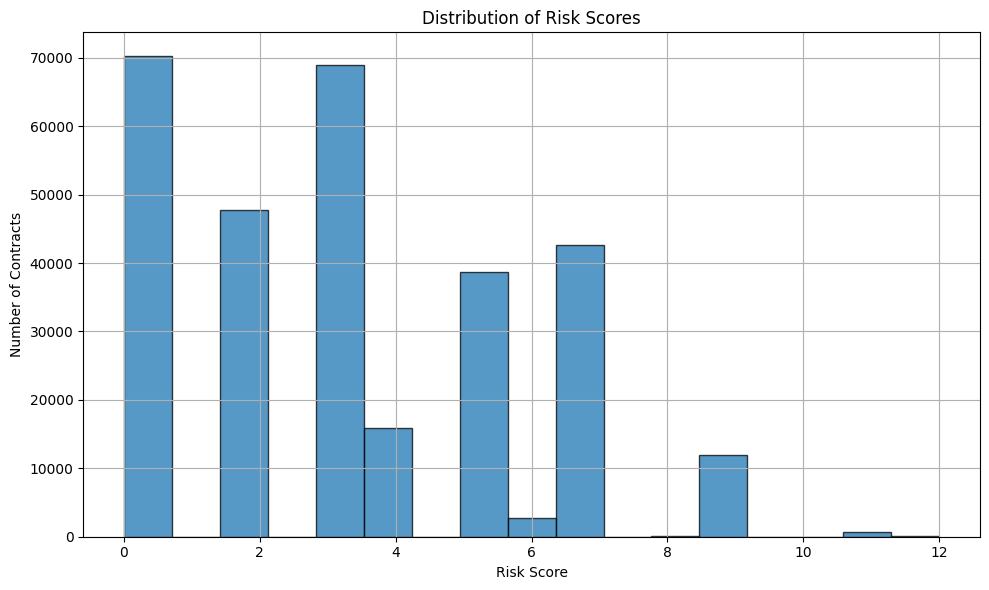

In [11]:
# Drop missing values
risk_scores = contracts_enriched["RISK_SCORE"].dropna()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(risk_scores, bins = 17, edgecolor = 'black', alpha = 0.75)
plt.title("Distribution of Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Number of Contracts")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
contracts_enriched.isna().sum()

MATCH_KEY                         0
CONTRACT #                        0
PRESENTER                         0
FIRST ARTIST                      0
FIRST EVENT DATE                  0
NO. OF SHOWS                      0
AGENT                             0
TYPE                              0
STATUS                            0
$GROSS                            0
$ECE TOTAL COMMISSION             0
ARTIST NET                        0
ISSUE DATE                        0
OVERDUE DEPOSIT                   0
OVERDUE SIGNATURE                 0
OUT OF BALANCE                    0
UNDERWATER                        0
IS ARCHIVED                       0
$DEPOSIT DUE AMOUNT               0
VENUE NAME                        0
VENUE CITY/STATE                  0
CONTACT NAME                      0
OFFICE                            0
LINE OF BUSINESS                  0
ARTIST NET_CLEANED                0
EVENT DATE YEAR                   1
PRESENTER_CLEAN                   0
VENUE_CLEAN                 

In [12]:
contracts_enriched.drop(columns = ['# BLUE CARD', 'CREATED DATE',
                        'EVENT_DATE_CLEAN_BLUECARD'], inplace = True)

contracts_enriched.dropna(subset = ['ISSUE_TO_EVENT_DAYS'], inplace = True)

contracts_enriched.isna().sum()

MATCH_KEY                  0
CONTRACT #                 0
PRESENTER                  0
FIRST ARTIST               0
FIRST EVENT DATE           0
NO. OF SHOWS               0
AGENT                      0
TYPE                       0
STATUS                     0
$GROSS                     0
$ECE TOTAL COMMISSION      0
ARTIST NET                 0
ISSUE DATE                 0
OVERDUE DEPOSIT            0
OVERDUE SIGNATURE          0
OUT OF BALANCE             0
UNDERWATER                 0
IS ARCHIVED                0
$DEPOSIT DUE AMOUNT        0
VENUE NAME                 0
VENUE CITY/STATE           0
CONTACT NAME               0
OFFICE                     0
LINE OF BUSINESS           0
ARTIST NET_CLEANED         0
EVENT DATE YEAR            0
PRESENTER_CLEAN            0
VENUE_CLEAN                0
AGENT_CLEAN                0
EVENT_DATE_CLEAN           0
OVERDUE_DEPOSIT_FLAG       0
OVERDUE_SIGNATURE_FLAG     0
STATUS_RISK_FLAG           0
FINANCIAL_DELTA            0
ISSUE_TO_EVENT

In [13]:
features = [
    'AGENT_CLEAN',
    'ISSUE_TO_EVENT_DAYS', 'IS_FIRST_TIME_PRESENTER', 'FINANCIAL_DELTA',
    'STATUS_RISK_FLAG'
]

X = contracts_enriched[features]

label_encoders = {}
for col in ['AGENT_CLEAN']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

y = contracts_enriched['RISK_SCORE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 24)

'''
model = HistGradientBoostingRegressor(random_state=24)

params = {
    "learning_rate": [0.05, 0.1],
    "max_iter": [100, 150],
    "max_depth": [4, 6, 8]
}

search = GridSearchCV(model, param_grid = params, scoring = 'r2', cv = 3)
search.fit(X_train, y_train)

print("Best Params:", search.best_params_)
'''

/tmp/ipykernel_3997/3545173706.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))


'\nmodel = HistGradientBoostingRegressor(random_state=24)\n\nparams = {\n    "learning_rate": [0.05, 0.1],\n    "max_iter": [100, 150],\n    "max_depth": [4, 6, 8]\n}\n\nsearch = GridSearchCV(model, param_grid = params, scoring = \'r2\', cv = 3)\nsearch.fit(X_train, y_train)\n\nprint("Best Params:", search.best_params_)\n'

In [14]:
best_model = HistGradientBoostingRegressor(learning_rate = 0.1,
                            max_depth = 8,
                            max_iter = 150,
                            random_state = 24)

best_model.fit(X_train, y_train)

# Predictions and metrics
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
r2 = r2_score(y_test, y_pred)

mae, rmse, r2

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(0.6786440807725509, 0.9698319054885294, 0.8597820545901589)

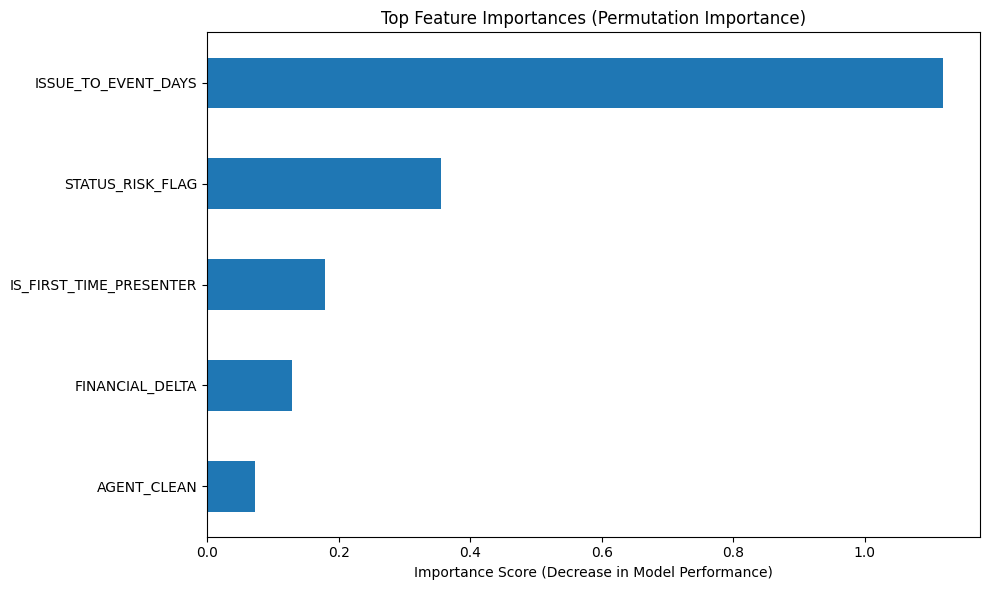

In [15]:
result = permutation_importance(best_model, X, y, n_repeats = 10, random_state = 24)

# Convert to Series
importances = pd.Series(result.importances_mean, index = X.columns).sort_values(
                                                                ascending = False)

# Plot features
top_n = 11
plt.figure(figsize = (10, 6))
importances.head(top_n).plot(kind = 'barh')
plt.title("Top Feature Importances (Permutation Importance)")
plt.xlabel("Importance Score (Decrease in Model Performance)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [16]:
import joblib
package_to_save = {
    'model': best_model,
    'encoders': label_encoders
}
joblib.dump(package_to_save, 'risk_score_model.pkl')

['risk_score_model.pkl']

In [17]:
package = joblib.load('risk_score_model.pkl')
print(package.keys())

dict_keys(['model', 'encoders'])
